In [63]:
import numpy as np
import matplotlib.pyplot as plt
from GroupingAlgorithms import *
from functions_VQE_v2 import *
# Importing standard Qiskit libraries
from qiskit import IBMQ, providers
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit.opflow import converters
from qiskit.opflow.primitive_ops import Z2Symmetries

In [2]:
IBMQ.load_account()
provider  = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic') 
backend   = provider.get_backend('ibmq_paris')
WC_paris  = get_backend_conectivity(backend)
backend   = providers.aer.AerSimulator(method="statevector") # Backend for simulation
NUM_SHOTS = 2**13  # Number of shots for each circuit

In [3]:
num_qubits = 2
np.random.seed(254651)
qubit_op   = HeisenbergHamiltonian()
WC=list(range(num_qubits))
WC=list(permutations(list(range(num_qubits)),2))
print( qubit_op )

SummedOp([
  -1 * IZ,
  -1 * ZI,
  -1 * XX,
  -1 * YY,
  -1 * ZZ
])


In [4]:
exact_result = NumPyEigensolver(qubit_op).run()
exact_energy = np.real(exact_result.eigenvalues)[0]
exact_energy

C:\Users\Luciano\Anaconda3\lib\site-packages\qiskit\aqua\algorithms\eigen_solvers\eigen_solver.py:38: DeprecationWarning: The package qiskit.aqua.algorithms.eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')
C:\Users\Luciano\Anaconda3\lib\site-packages\qiskit\aqua\operators\operator_base.py:46: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('aqua.operators', 'qiskit.opflow', 'qiskit-terra')


-3.000000000000001

In [5]:
paulis, coeff, label = Label2Chain(qubit_op)
print( 'number of Paulis:', len(coeff) )

Color, Groups_tpb, Measurements_tpb = TPBgrouping(paulis)
print( 'number of TPB groups:', len(Groups_tpb) )
Groups_tpb = [ [ idx2[0] for idx2 in idx1 ] for idx1 in Groups_tpb ]
Measurements_tpb = [ [ [idx[j][0],[j]] for j in range(num_qubits) ] for idx in Measurements_tpb ]

Groups_bell, Measurements_bell = grouping( paulis,[4,3,1,2],WC)
print('number of Bell groups:', len(Groups_bell) )

Groups_bell_paris, Measurements_bell_paris = grouping( paulis,[4,3,1,2],WC_paris)
print('number of Bell groups in ibmq_paris:', len(Groups_bell_paris) )

number of Paulis: 5
number of TPB groups: 3
number of Bell groups: 2
number of Bell groups in ibmq_paris: 2


D:\Saco_CSIC\Programas\Github\Hardware-efficient-variational-quantum-eigensolver-with-entangled-measurements\Codes\GroupingAlgorithms.py:118: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if (list(Vi[[per]]) in Comp[Eps]) and (list(Vj[[per]]) in Comp[Eps]):


In [6]:
paulis

array([[0, 3],
       [3, 0],
       [1, 1],
       [2, 2],
       [3, 3]])

In [7]:
Measurements_tpb

[[[1, [0]], [1, [1]]], [[2, [0]], [2, [1]]], [[3, [0]], [3, [1]]]]

In [8]:
Measurements_bell

[[[4, [0, 1]]], [[3, [0]], [3, [1]]]]

In [9]:
Measurements_bell_paris

[[[4, [0, 1]]], [[3, [0]], [3, [1]]]]

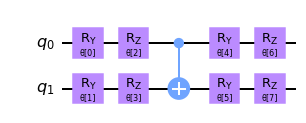

In [10]:
entangled_layer = []
for qbs in WC_paris :
    if qbs[0]<qbs[1] and qbs[1]<num_qubits :
        entangled_layer.append(qbs)

ansatz = EfficientSU2(num_qubits,['ry','rz'], entanglement=entangled_layer, reps=1)
ansatz.draw(output='mpl')

In [11]:
num_var = 4*num_qubits
θ = np.random.randn(num_var)
qc = []
n_measure = []
for measure in Measurements_bell :
    qc_temp, n_measure_temp = measure_circuit_factor( measure , num_qubits )
    qc_temp = qc_temp.compose(ansatz.assign_parameters(θ),front=True )
    qc.append( qc_temp )
    n_measure.append( n_measure_temp )

In [12]:
counts = backend.run(qc,shots=NUM_SHOTS).result().get_counts()
counts

[{'01': 3674, '11': 926, '00': 2798, '10': 794},
 {'0 0': 5316, '1 1': 1163, '0 1': 1633, '1 0': 80}]

In [13]:
probabilities = [ post_process_results(counts[0], num_qubits, NUM_SHOTS), post_process_results(counts[1], num_qubits, NUM_SHOTS) ]
probabilities

[array([0.34155273, 0.44848633, 0.09692383, 0.11303711]),
 array([0.64892578, 0.19934082, 0.00976562, 0.14196777])]

In [14]:
Bell = np.array([ [1,0,0,1], [1,0,0,-1], [0,1,1,0], [0,1,-1,0] ]).T/np.sqrt(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.array([[1,0],[1,0]])

In [15]:
B0 = []
for M in [X,Y,Z]:
    B0.append( np.diag(Bell.T.conj()@np.kron(M,M)@Bell) )
B0 = np.array(B0)
B1 = np.array([ [1,1,-1,-1], [1,-1,1,-1] ])
B = [B0,B1]
B

[array([[ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j],
        [-1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j],
        [ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j]]),
 array([[ 1,  1, -1, -1],
        [ 1, -1,  1, -1]])]

In [16]:
EV0 = B0@probabilities[0]
EV0

array([-0.12304687+0.j,  0.09082031+0.j,  0.58007812+0.j])

In [17]:
EV1 = B1@probabilities[1]
EV1

array([0.6965332 , 0.31738281])

In [18]:
-np.sum(EV0)-np.sum(EV1)

(-1.561767578125-0j)

In [19]:
Hamiltonian = qubit_op.to_matrix()
qc_state = ansatz.assign_parameters(θ)
qc_state.save_statevector()
state = backend.run(qc_state).result().get_statevector()
np.vdot( state, Hamiltonian@state )

(-1.564908909208547+5.551115123125783e-17j)

In [20]:
Measurements_bell

[[[4, [0, 1]]], [[3, [0]], [3, [1]]]]

In [21]:
probability2expected(coeff, label, Groups_bell, Measurements_bell)

[array([[ 1, -1,  1, -1],
        [-1,  1,  1, -1],
        [ 1,  1, -1, -1]]),
 array([[ 1.,  1., -1., -1.],
        [ 1., -1.,  1., -1.]])]

In [22]:
B

[array([[ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j],
        [-1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j],
        [ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j]]),
 array([[ 1,  1, -1, -1],
        [ 1, -1,  1, -1]])]

In [23]:
label

['IZ', 'ZI', 'XX', 'YY', 'ZZ']

In [24]:
fun1 = lambda params : objective_function(params, coeff, label, Groups_tpb, Measurements_tpb, ansatz, backend, NUM_SHOTS)
fun2 = lambda params : objective_function(params, coeff, label, Groups_bell, Measurements_bell, ansatz, backend, NUM_SHOTS)
fun3 = lambda params : objective_function(params, coeff, label, Groups_bell_paris, Measurements_bell_paris, ansatz, backend, NUM_SHOTS)

In [25]:
fun1(θ)

-1.57080078125

In [26]:
fun2(θ)

-1.556640625

In [27]:
fun3(θ)

-1.5576171875

In [53]:
num_qubits = 3
np.random.seed(254652)
qubit_op   = RandomHamiltonian(num_qubits,num_qubits**3)
WC=list(range(num_qubits))
WC=list(permutations(list(range(num_qubits)),2))
print( qubit_op )

SummedOp([
  YIZ,
  IXX,
  ZXY,
  ZXI,
  XII,
  III,
  ZYX,
  ZIZ,
  ZYY,
  YXI,
  IYZ,
  IXZ,
  XYX,
  ZYI,
  IXZ,
  XXY,
  XXX,
  XZI,
  XXZ,
  ZXY,
  YXY,
  ZYI,
  YIX,
  ZXI,
  XZX,
  ZZX,
  YII
])


In [54]:
paulis, coeff, label = Label2Chain(qubit_op)
print( 'number of Paulis:', len(coeff) )

Color, Groups_tpb, Measurements_tpb = TPBgrouping(paulis)
print( 'number of TPB groups:', len(Groups_tpb) )
Groups_tpb = [ [ idx2[0] for idx2 in idx1 ] for idx1 in Groups_tpb ]
Measurements_tpb = [ [ [idx[j][0],[j]] for j in range(num_qubits) ] for idx in Measurements_tpb ]

Groups_bell, Measurements_bell = grouping( paulis,[4,3,1,2],WC)
print('number of Bell groups:', len(Groups_bell) )

Groups_bell_paris, Measurements_bell_paris = grouping( paulis,[4,3,1,2],WC_paris)
print('number of Bell groups in ibmq_paris:', len(Groups_bell_paris) )

number of Paulis: 27
number of TPB groups: 13
number of Bell groups: 11
number of Bell groups in ibmq_paris: 12


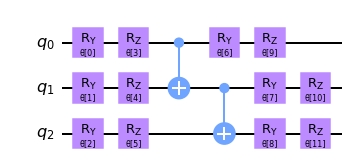

In [55]:
entangled_layer = []
for qbs in WC_paris :
    if qbs[0]<qbs[1] and qbs[1]<num_qubits :
        entangled_layer.append(qbs)

ansatz = EfficientSU2(num_qubits,['ry','rz'], entanglement=entangled_layer, reps=1)
ansatz.draw(output='mpl')

In [56]:
num_var = 4*num_qubits
θ = np.random.randn(num_var)
Hamiltonian = qubit_op.to_matrix()
qc_state = ansatz.assign_parameters(θ)
qc_state.save_statevector()
state = backend.run(qc_state).result().get_statevector()
np.vdot( state, Hamiltonian@state )

(-1.8935057108439746+1.6653345369377348e-16j)

In [57]:
fun1 = lambda params : objective_function(params, coeff, label, Groups_tpb, Measurements_tpb, ansatz, backend, NUM_SHOTS)
fun2 = lambda params : objective_function(params, coeff, label, Groups_bell, Measurements_bell, ansatz, backend, NUM_SHOTS)
fun3 = lambda params : objective_function(params, coeff, label, Groups_bell_paris, Measurements_bell_paris, ansatz, backend, NUM_SHOTS)

In [58]:
MC = 100

In [59]:
f1 = []
for _ in range(MC):
    f1.append( fun1(θ) )
np.mean(f1)

-1.90447021484375

(array([ 1.,  6., 14., 16., 21., 16., 12.,  9.,  3.,  2.]),
 array([-2.05981445, -2.02675781, -1.99370117, -1.96064453, -1.92758789,
        -1.89453125, -1.86147461, -1.82841797, -1.79536133, -1.76230469,
        -1.72924805]),
 <a list of 10 Patch objects>)

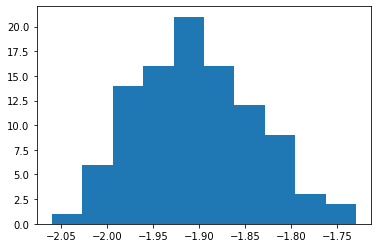

In [64]:
plt.hist(f1)

In [60]:
f2 = []
for _ in range(MC):
    f2.append( fun2(θ) )
np.mean(f2)

-1.902431640625

(array([ 5.,  8.,  8., 13., 23., 17.,  9.,  9.,  6.,  2.]),
 array([-2.02685547, -2.00021973, -1.97358398, -1.94694824, -1.9203125 ,
        -1.89367676, -1.86704102, -1.84040527, -1.81376953, -1.78713379,
        -1.76049805]),
 <a list of 10 Patch objects>)

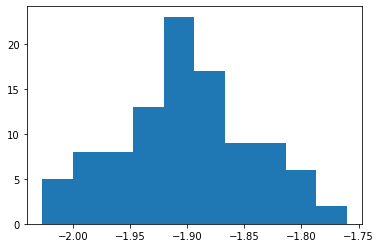

In [65]:
plt.hist(f2)

In [61]:
f3 = []
for _ in range(MC):
    f3.append( fun3(θ) )
np.mean(f3)

-1.887841796875